In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(
    "mrmaazoo/breast-ultrasound-classification",
)

print("Path to dataset files:", path)



d:\User\毒蛇\Documents\GitHub\The_Practice_of_Deep_Learning_Biomedical_Image_analysis_Final_Exam\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ihvgj\.cache\kagglehub\datasets\mrmaazoo\breast-ultrasound-classification\versions\1


<>:6: SyntaxWarning: invalid escape sequence '\B'
<>:6: SyntaxWarning: invalid escape sequence '\B'
C:\Users\ihvgj\AppData\Local\Temp\ipykernel_34300\1102160444.py:6: SyntaxWarning: invalid escape sequence '\B'
  DATA_DIR = path + "\BUSI_Corrected"


Found 750 files belonging to 3 classes.
Using 600 files for training.
Found 750 files belonging to 3 classes.
Using 150 files for validation.
['benign', 'malignant', 'normal']


<unknown>:6: SyntaxWarning: invalid escape sequence '\B'
<unknown>:6: SyntaxWarning: invalid escape sequence '\B'
d:\User\毒蛇\Documents\GitHub\The_Practice_of_Deep_Learning_Biomedical_Image_analysis_Final_Exam\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.4965 - loss: 1.0316 - val_accuracy: 0.5400 - val_loss: 0.9953
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 461ms/step - accuracy: 0.5699 - loss: 0.9903 - val_accuracy: 0.5400 - val_loss: 0.9893
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - accuracy: 0.5540 - loss: 0.9900 - val_accuracy: 0.5400 - val_loss: 0.9904
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.5458 - loss: 0.9997 - val_accuracy: 0.5400 - val_loss: 0.9967
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 435ms/step - accuracy: 0.5529 - loss: 0.9939 - val_accuracy: 0.5400 - val_loss: 0.9904
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 442ms/step - accuracy: 0.5531 - loss: 1.0020 - val_accuracy: 0.5400 - val_loss: 0.9948
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 435ms/step - accuracy: 0.5268 - loss: 1.0067 - val_accuracy: 0.5400 - val_loss: 0.9884
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step - accuracy: 0.5283 - loss: 1.0175 - val_acc

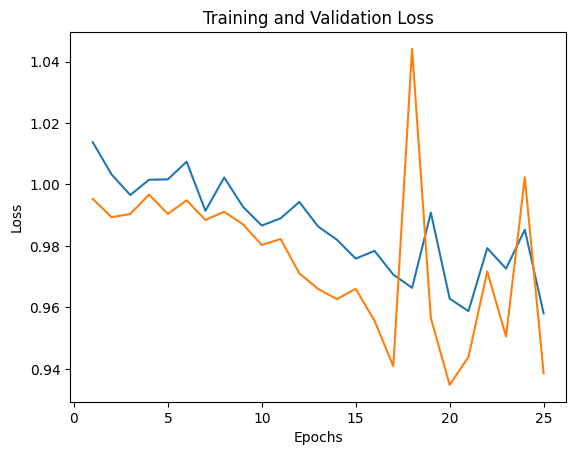

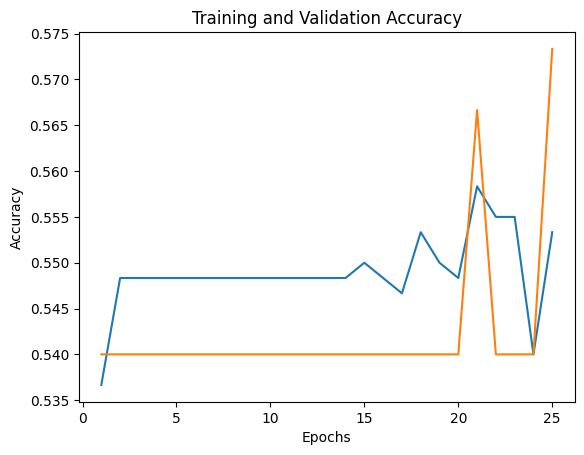

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 資料集目錄結構
DATA_DIR = path + "\BUSI_Corrected"

# 參數設定
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2, subset="training", seed=42,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2, subset="validation", seed=42,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

print(train_ds.class_names)

# 資料增強與前處理
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
preprocess_input = layers.Rescaling(1./255)

def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds = prepare(val_ds, training=False)

# 建立並編譯模型
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"), layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 訓練並取得 history
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)

# 繪製指標
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure()
plt.plot(epochs, history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

plt.figure()
plt.plot(epochs, history_dict['accuracy'])
plt.plot(epochs, history_dict['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()


In [3]:
import tensorflow as tf

# 1. 列出可用的 GPU
gpus = tf.config.list_physical_devices('GPU')
print("Detected GPUs:", gpus)

Detected GPUs: []
